# Anomaly Detection Approaches
### Author : Raghva Sharma

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind,ttest_1samp
import warnings
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint
warnings.filterwarnings('ignore')

In [203]:
class PCAExec:
    
    def __init__(self,data,features):
        self.data = data
        self.features = features
    
    def numberOfPCAComponents(self,varthresh):
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        import matplotlib.pyplot as plt
        # Standardize the data
        scalar = StandardScaler()
        scalar.fit(self.data[self.features])
        X = scalar.transform(self.data[self.features])
        # Identify number of PC's explaining 80% variance
        pca = PCA()
        pca.fit(X)
        exp_var = pca.explained_variance_ratio_.cumsum()
        print ("Explained Variance ",exp_var)
        inds = np.where(np.array(exp_var)>varthresh)
        ncomps = inds[0][0]+1
        
        plt.plot(exp_var)
        plt.axhline(varthresh,c='r',linestyle='--')
        plt.axvline(ncomps-1,c='black',linestyle='--')
        plt.xlabel("Number of components including Zero")
        plt.ylabel("Explained Variance")
        return ncomps, scalar
    
    def pcaFit(self,ncomps,scalar,alph=0.05):
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        import matplotlib.pyplot as plt
        import seaborn as sns
        from scipy.stats import f,norm,t
        X = scalar.transform(self.data[self.features])
        pca = PCA(n_components=ncomps)
        pca.fit(X)
        Xpctransform = pca.transform(X)
        Xinvpctransform = pca.inverse_transform(Xpctransform)
        # Squared prediction error & Q-statistic
        X_err = (X - Xinvpctransform)**2 # Error in each parameter
        Q = np.sum((X - Xinvpctransform)**2,axis=1) # Squared prediction error
        eigvals,eigvec = np.linalg.eig(np.dot(X.T,X)/(X.shape[0]-1))
        eigvals_selected = eigvals.real[0:Xpctransform.shape[1]]
        eigvals_excluded = eigvals.real[Xpctransform.shape[1]:] # These contribute to the error
        theta1 = sum(eigvals_excluded)
        theta2 = sum(eigvals_excluded*eigvals_excluded)
        theta3 = sum(eigvals_excluded*eigvals_excluded*eigvals_excluded)
        h0 = 1 - 2*(theta1*theta3)/(3*theta2**2)
        calpha = norm.ppf(1-alph,loc=0,scale=1)
        Qstatistic = theta1*((calpha*h0*(2*theta2)**0.5)/theta1 + 1 + (theta2*h0*(h0-1.0)/theta1**2))**(1/h0)
        # Multivariate T statistic (T^2 statistic)
        Pcomp = pca.components_
        t2value = [X[i].dot(Pcomp.T).dot(np.linalg.inv(np.diag(eigvals_selected))).dot(Pcomp).dot(X[i].T) for i in range(0,len(X))]
        falpha = f.ppf(1.0-alph,Xpctransform.shape[1],Xpctransform.shape[0]-Xpctransform.shape[1])
        t2statistic = Xpctransform.shape[1]*(Xpctransform.shape[0]**2-1.0)*falpha/(Xpctransform.shape[0]*(Xpctransform.shape[0]-Xpctransform.shape[1]))
        self.data['Q'] = Q
        self.data['t2'] = t2value
        return pca,Qstatistic,t2statistic,X_err
        
    
    def pcaTest(self,scalar,pca,Qstat,t2stat):
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        import matplotlib.pyplot as plt
        import seaborn as sns
        from scipy.stats import f,norm,t
        X = scalar.transform(self.data[self.features])
        Xpctransform = pca.transform(X)
        Xinvpctransform = pca.inverse_transform(Xpctransform)
        # Squared prediction error & Q-statistic
        X_err = (X - Xinvpctransform)**2 # Error in each parameter
        Q = np.sum((X - Xinvpctransform)**2,axis=1) # Squared prediction error
        eigvals,eigvec = np.linalg.eig(np.dot(X.T,X)/(X.shape[0]-1))
        eigvals_selected = eigvals.real[0:Xpctransform.shape[1]]
        eigvals_excluded = eigvals.real[Xpctransform.shape[1]:] # These contribute to the error
        # Multivariate T statistic (T^2 statistic)
        Pcomp = pca.components_
        t2value = [X[i].dot(Pcomp.T).dot(np.linalg.inv(np.diag(eigvals_selected))).dot(Pcomp).dot(X[i].T) for i in range(0,len(X))]
        self.data['Q'] = Q
        self.data['t2value'] = t2value
        self.data['outlier'] = 'normal'
        self.data.loc[self.data['Q']>Qstat,'outlier']='Q-out'
        self.data.loc[self.data['t2value']>t2stat,'outlier']='t2-out'
        plt.figure()
        sns.scatterplot(Xpctransform[:,0],Xpctransform[:,1],hue=self.data['outlier'])
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.figure()
        sns.scatterplot(t2value,Q,hue=self.data['Class'],palette='tab10')
        plt.axhline(Qstat,linestyle='--',c='r')
        plt.axvline(t2stat,linestyle='--',c='r')
        plt.xlabel('T2')
        plt.ylabel('Q')
        return X_err

In [204]:
class autoEncoder:
    def __init__(self,data,features):
        self.data=data
        self.features = features
    
    def ae_normal(self):
        #X = np.asarray(df)
        mmsclr = MinMaxScaler()
        X = mmsclr.fit_transform(self.data[self.features])
        inp_sh = X.shape[1]
        inp_layer = Input(shape=(inp_sh,)) # Input layer passing all the columns
        # First layer of encoding
        en1 = Dense(50)(inp_layer)
        en1 = BatchNormalization()(en1)
        en1 = ReLU()(en1)
        # Second Layer of encoding
        en1 = Dense(15)(en1)
        en1 = BatchNormalization()(en1)
        en1 = ReLU()(en1)
        # Throat or bottle neck layer
        bn = Dense(5)(en1)
        # First Decoding layer
        de1 = Dense(15)(bn)
        de1 = BatchNormalization()(de1)
        de1 = ReLU()(de1)
        # Second Decoding Layer
        de1 = Dense(50)(de1)
        de1 = BatchNormalization()(de1)
        de1 = ReLU()(de1)    
        # Output layer
        op_layer = Dense(inp_sh,activation='linear')(de1)
        model = Model(inputs=inp_layer,outputs=op_layer)
        model.compile(optimizer="adam",loss="mse",metrics="mean_squared_error")
        # save the model history to view the convergence
        checkpoint_filepath=r'F:\backup\practice\machine_learning\best_model'
        model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_mean_squared_error',
        mode='max',
        save_best_only=True)

        history = model.fit(X,X,epochs=200,validation_split=0.3,batch_size=16,callbacks=[model_checkpoint_callback])
        # Convergence plot
        plt.figure()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        encoder_model = Model(inputs=inp_layer,outputs=bn)
        model.load_weights(checkpoint_filepath)
        return model,history,encoder_model,mmsclr

In [205]:
dt = pd.read_csv(r'F:/backup/practice/machine_learning/wine.csv')
print(dt.columns)
dt.describe()

Index(['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash  ',
       'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')


,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [206]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Class                         178 non-null    int64  
 1   Alcohol                       178 non-null    float64
 2   Malic acid                    178 non-null    float64
 3   Ash                           178 non-null    float64
 4   Alcalinity of ash             178 non-null    float64
 5   Magnesium                     178 non-null    int64  
 6   Total phenols                 178 non-null    float64
 7   Flavanoids                    178 non-null    float64
 8   Nonflavanoid phenols          178 non-null    float64
 9   Proanthocyanins               178 non-null    float64
 10  Color intensity               178 non-null    float64
 11  Hue                           178 non-null    float64
 12  OD280/OD315 of diluted wines  178 non-null    float64
 13  Proli

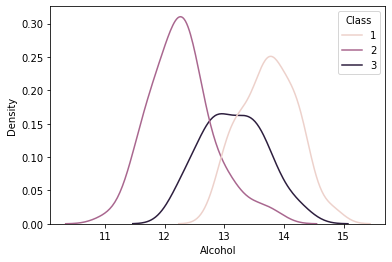

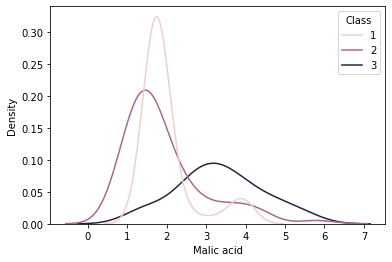

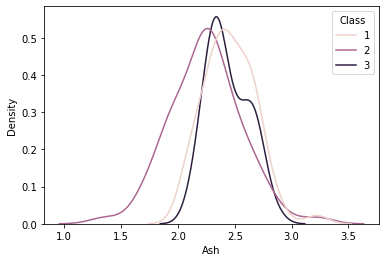

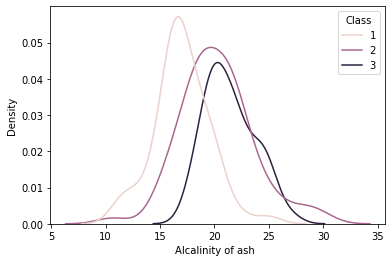

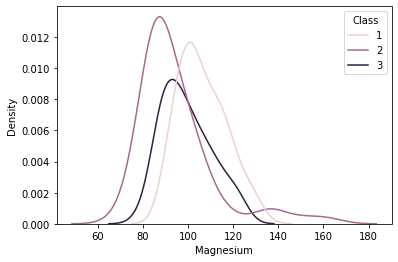

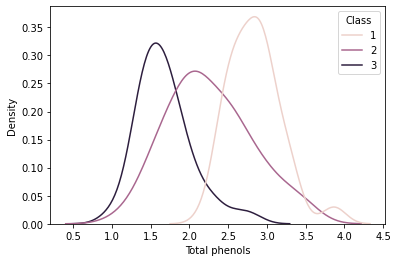

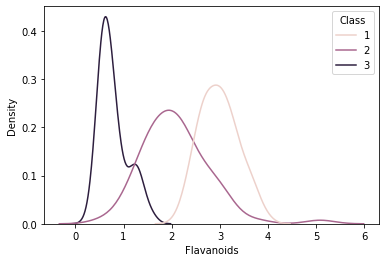

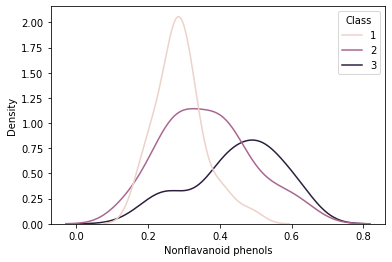

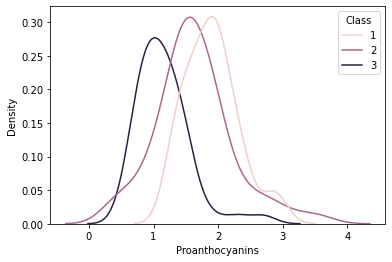

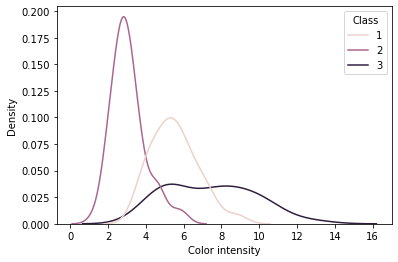

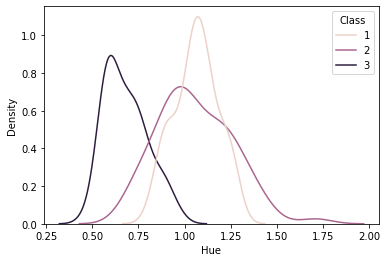

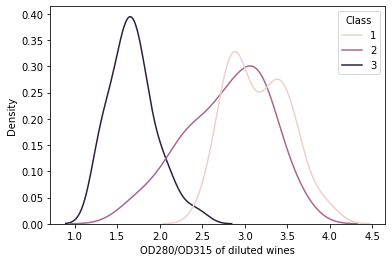

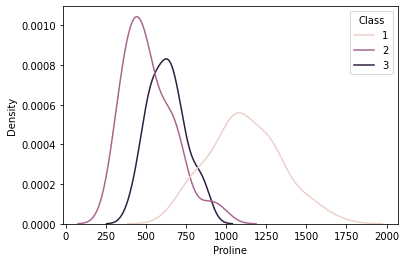

In [207]:
for i in dt.columns:
    if (i != 'Class'):
        plt.figure()
        sns.kdeplot(dt[i],hue=dt['Class'])
    else:
        continue

<AxesSubplot:>

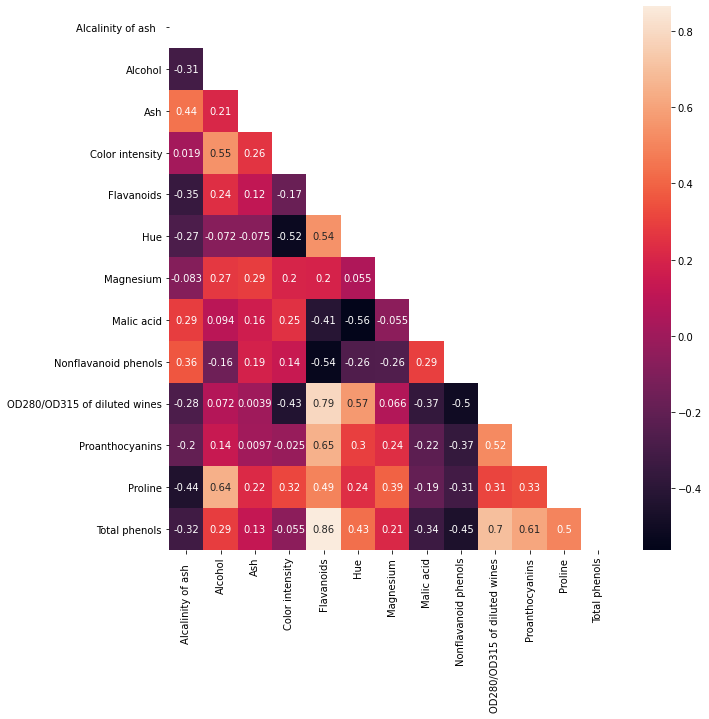

In [208]:
# Check multicollinearity
cols = dt[dt.columns.difference(['Class'])].columns
mask = np.triu(np.ones_like(dt[cols].corr()))
plt.figure(figsize=(10,10))
sns.heatmap(dt[cols].corr(),annot=True,mask=mask)

In [209]:
# Perform Statistical hypothesis testing using T statistic on the trained error means and test error means
# Null Hypothesis : There is no differnce between samples from training and testing (Accept if P > 0.05) 
# Alternate Hypothesis : Parameter is significant in differentiating training and testing samples (Accept if P < 0.05)
def anomaly_contr(train_err,test_err,cols):
    #test_err = np.asarray(df[cols])
    samples = min(len(test_err),len(train_err))
    train_err = train_err.sample(samples)
    test_err = test_err.sample(samples)
    #test_err = test_err.mean(axis=0)
    print("Statistical test Results")
    print("========================")
    for i in cols:
        t,p=ttest_ind(np.asarray(train_err[i]),np.asarray(test_err[i]),equal_var=False) # Welsch - t test
        res = "Not Contributing for the anomaly"
        if (p<0.05):
            res = "Contributing for the anomaly"
        print(i," is ",res)

## PCA Model

Explained Variance  [0.36532201 0.51698386 0.63748367 0.7195399  0.77766642 0.83254361
 0.87389249 0.91037896 0.94086917 0.95920468 0.97498127 0.98913717
 1.        ]
Statistical test Results
Alcalinity of ash    is  Contributing for the anomaly
Alcohol  is  Contributing for the anomaly
Ash  is  Contributing for the anomaly
Color intensity  is  Contributing for the anomaly
Flavanoids  is  Contributing for the anomaly
Hue  is  Not Contributing for the anomaly
Magnesium  is  Contributing for the anomaly
Malic acid  is  Contributing for the anomaly
Nonflavanoid phenols  is  Contributing for the anomaly
OD280/OD315 of diluted wines  is  Contributing for the anomaly
Proanthocyanins  is  Contributing for the anomaly
Proline  is  Contributing for the anomaly
Total phenols  is  Contributing for the anomaly


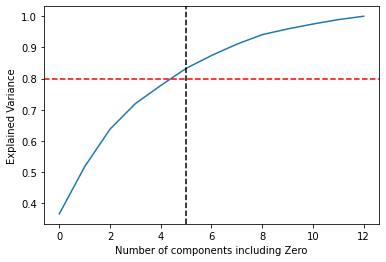

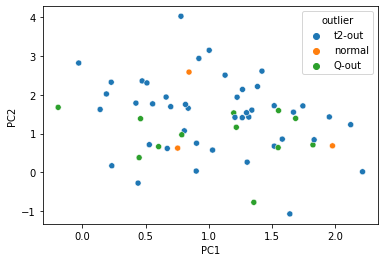

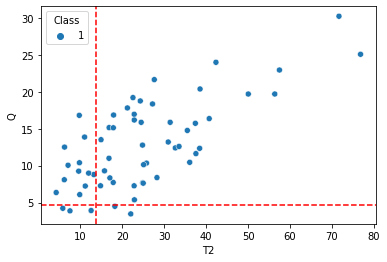

In [210]:
# Anything above Q and T2 threshold is an outlier
dt_normal = dt[dt['Class']>1]
pcobj = PCAExec(dt_normal,cols)
ncomps,scalar = pcobj.numberOfPCAComponents(0.8)
pca,qstat,t2stat,X_err_train = pcobj.pcaFit(ncomps,scalar)
train_err = pd.DataFrame(X_err_train,columns=cols)
fullData = PCAExec(dt[dt['Class']==1],cols)
X_err_test = fullData.pcaTest(scalar,pca,qstat,t2stat)
test_err = pd.DataFrame(X_err_test,columns=cols)
anomaly_contr(train_err,test_err,cols)

# Auto Encoders

Epoch 1/200
6/6 [==============================] - 4s 109ms/step - loss: 0.9476 - mean_squared_error: 0.9476 - val_loss: 0.2192 - val_mean_squared_error: 0.2192
Epoch 2/200
6/6 [==============================] - 0s 20ms/step - loss: 0.7338 - mean_squared_error: 0.7338 - val_loss: 0.2144 - val_mean_squared_error: 0.2144
Epoch 3/200
6/6 [==============================] - 0s 22ms/step - loss: 0.5492 - mean_squared_error: 0.5492 - val_loss: 0.2083 - val_mean_squared_error: 0.2083
Epoch 4/200
6/6 [==============================] - 0s 22ms/step - loss: 0.4268 - mean_squared_error: 0.4268 - val_loss: 0.2019 - val_mean_squared_error: 0.2019
Epoch 5/200
6/6 [==============================] - 0s 21ms/step - loss: 0.3282 - mean_squared_error: 0.3282 - val_loss: 0.1956 - val_mean_squared_error: 0.1956
Epoch 6/200
6/6 [==============================] - 0s 22ms/step - loss: 0.2617 - mean_squared_error: 0.2617 - val_loss: 0.1897 - val_mean_squared_error: 0.1897
Epoch 7/200
6/6 [======================

6/6 [==============================] - 0s 37ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0904 - val_mean_squared_error: 0.0904
Epoch 52/200
6/6 [==============================] - 0s 35ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0879 - val_mean_squared_error: 0.0879
Epoch 53/200
6/6 [==============================] - 0s 33ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0854 - val_mean_squared_error: 0.0854
Epoch 54/200
6/6 [==============================] - ETA: 0s - loss: 0.0424 - mean_squared_error: 0.04 - 0s 32ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0824 - val_mean_squared_error: 0.0824
Epoch 55/200
6/6 [==============================] - 0s 35ms/step - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0798 - val_mean_squared_error: 0.0798
Epoch 56/200
6/6 [==============================] - 0s 30ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0764 - val_mean_squared_error: 0.

6/6 [==============================] - 0s 24ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 102/200
6/6 [==============================] - 0s 27ms/step - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 0.0476 - val_mean_squared_error: 0.0476
Epoch 103/200
6/6 [==============================] - 0s 34ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 104/200
6/6 [==============================] - 0s 33ms/step - loss: 0.0324 - mean_squared_error: 0.0324 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoch 105/200
6/6 [==============================] - 0s 32ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 106/200
6/6 [==============================] - 0s 29ms/step - loss: 0.0322 - mean_squared_error: 0.0322 - val_loss: 0.0455 - val_mean_squared_error: 0.0455
Epoch 107/200
6/6 [=======================

6/6 [==============================] - 0s 21ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - val_loss: 0.0408 - val_mean_squared_error: 0.0408
Epoch 152/200
6/6 [==============================] - 0s 19ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.0413 - val_mean_squared_error: 0.0413
Epoch 153/200
6/6 [==============================] - 0s 25ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 154/200
6/6 [==============================] - 0s 19ms/step - loss: 0.0248 - mean_squared_error: 0.0248 - val_loss: 0.0391 - val_mean_squared_error: 0.0391
Epoch 155/200
6/6 [==============================] - 0s 23ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0373 - val_mean_squared_error: 0.0373
Epoch 156/200
6/6 [==============================] - 0s 24ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 157/200
6/6 [=======================

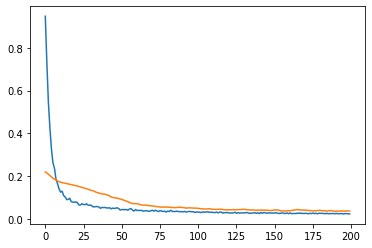

In [211]:
aennorm = autoEncoder(dt_normal,cols)
model, history, en_model, mmsclr = aennorm.ae_normal()

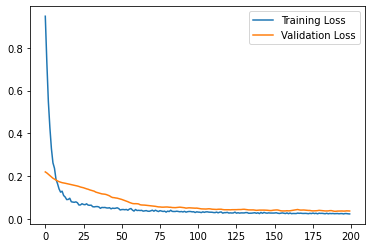

In [212]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

Statistical test Results
Alcalinity of ash    is  Contributing for the anomaly
Alcohol  is  Contributing for the anomaly
Ash  is  Not Contributing for the anomaly
Color intensity  is  Not Contributing for the anomaly
Flavanoids  is  Contributing for the anomaly
Hue  is  Not Contributing for the anomaly
Magnesium  is  Not Contributing for the anomaly
Malic acid  is  Not Contributing for the anomaly
Nonflavanoid phenols  is  Contributing for the anomaly
OD280/OD315 of diluted wines  is  Contributing for the anomaly
Proanthocyanins  is  Contributing for the anomaly
Proline  is  Contributing for the anomaly
Total phenols  is  Contributing for the anomaly


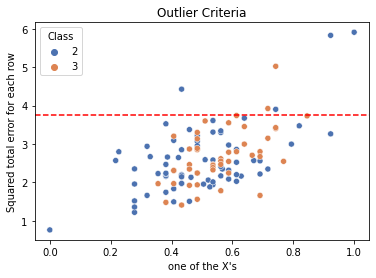

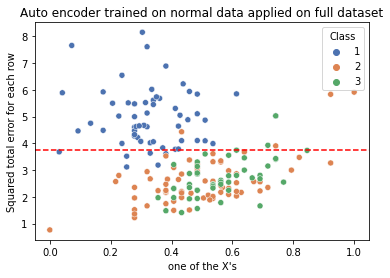

In [213]:
X_train = mmsclr.transform(dt_normal[cols])
resid_train = np.sum((X_train - model.predict(X_train))**2,axis=1)
#dt_ae_train = pd.DataFrame(resid_train,columns=cols)
outlier_criteria = np.quantile(resid_train,0.95)
plt.figure()
plt.title('Outlier Criteria')
sns.scatterplot(X_train[:,0],resid_train,hue=dt_normal['Class'],palette='deep')
plt.axhline(outlier_criteria,c='r',linestyle='--')
plt.xlabel("one of the X's")
plt.ylabel("Squared total error for each row")
resid_train = (X_train - model.predict(X_train))**2
dt_ae_train = pd.DataFrame(resid_train,columns=cols)

X_test = mmsclr.transform(dt[cols])
resid_test = np.sum((X_test - model.predict(X_test))**2,axis=1)
#dt_ae_test = pd.DataFrame(resid_test,columns=cols)
dt_ae_test['Class'] = dt['Class']
plt.figure()
plt.title('Auto encoder trained on normal data applied on full dataset')
sns.scatterplot(X_test[:,0],resid_test,hue=dt['Class'],palette='deep')
plt.axhline(outlier_criteria,c='r',linestyle='--')
plt.xlabel("one of the X's")
plt.ylabel("Squared total error for each row")
resid_test = (X_test - model.predict(X_test))**2
dt_ae_test = pd.DataFrame(resid_test,columns=cols)
anomaly_contr(dt_ae_train,dt_ae_test,cols)

## Autoencoder trained all classes of data (Simulating for data with out ground truth) 

In [214]:
from sklearn.model_selection import train_test_split

Epoch 1/200
6/6 [==============================] - 5s 159ms/step - loss: 0.8758 - mean_squared_error: 0.8758 - val_loss: 0.2179 - val_mean_squared_error: 0.2179
Epoch 2/200
6/6 [==============================] - 0s 27ms/step - loss: 0.6979 - mean_squared_error: 0.6979 - val_loss: 0.2127 - val_mean_squared_error: 0.2127
Epoch 3/200
6/6 [==============================] - 0s 26ms/step - loss: 0.5212 - mean_squared_error: 0.5212 - val_loss: 0.2069 - val_mean_squared_error: 0.2069
Epoch 4/200
6/6 [==============================] - 0s 26ms/step - loss: 0.3917 - mean_squared_error: 0.3917 - val_loss: 0.2010 - val_mean_squared_error: 0.2010
Epoch 5/200
6/6 [==============================] - 0s 27ms/step - loss: 0.3048 - mean_squared_error: 0.3048 - val_loss: 0.1950 - val_mean_squared_error: 0.1950
Epoch 6/200
6/6 [==============================] - 0s 23ms/step - loss: 0.2480 - mean_squared_error: 0.2480 - val_loss: 0.1893 - val_mean_squared_error: 0.1893
Epoch 7/200
6/6 [======================

6/6 [==============================] - 0s 12ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 0.0413 - val_mean_squared_error: 0.0413
Epoch 52/200
6/6 [==============================] - 0s 12ms/step - loss: 0.0341 - mean_squared_error: 0.0341 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 53/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - val_loss: 0.0391 - val_mean_squared_error: 0.0391
Epoch 54/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - val_loss: 0.0372 - val_mean_squared_error: 0.0372
Epoch 55/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - val_loss: 0.0356 - val_mean_squared_error: 0.0356
Epoch 56/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 57/200
6/6 [=============================

Epoch 102/200
6/6 [==============================] - 0s 21ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 103/200
6/6 [==============================] - 0s 33ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 104/200
6/6 [==============================] - 0s 32ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 105/200
6/6 [==============================] - 0s 35ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 106/200
6/6 [==============================] - 0s 36ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 107/200
6/6 [==============================] - 0s 38ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 108/200
6/6 [=========

6/6 [==============================] - 0s 32ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 153/200
6/6 [==============================] - 0s 25ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 154/200
6/6 [==============================] - 0s 20ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.0213 - val_mean_squared_error: 0.0213
Epoch 155/200
6/6 [==============================] - 0s 22ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.0216 - val_mean_squared_error: 0.0216
Epoch 156/200
6/6 [==============================] - 0s 21ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 157/200
6/6 [==============================] - 0s 22ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0213 - val_mean_squared_error: 0.0213
Epoch 158/200
6/6 [=======================

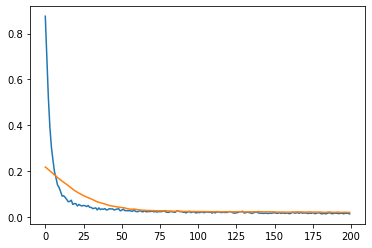

In [215]:
train,test = train_test_split(dt,stratify=dt['Class'],test_size=0.3,random_state=42)
train_set = autoEncoder(train,cols)
model,history,en_model, mmsclr_us = train_set.ae_normal()

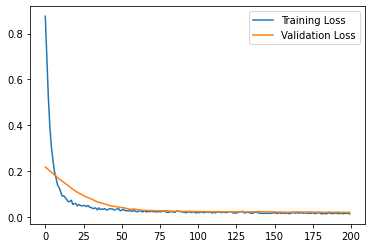

In [216]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

Text(0, 0.5, 'Squared total error for each row')

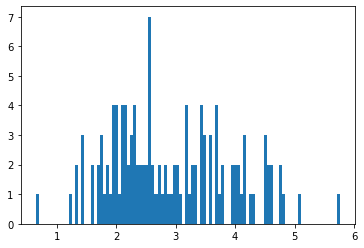

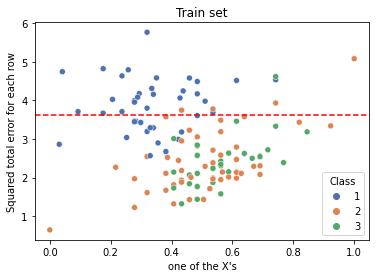

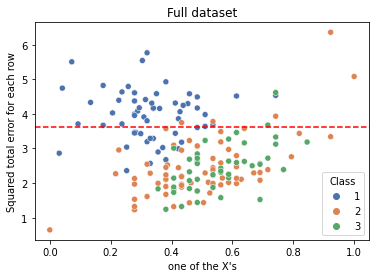

In [217]:
X_train = mmsclr_us.transform(train[cols])
resid = np.sum((X_train - model.predict(X_train))**2,axis=1)
plt.figure()
plt.hist(resid,bins=100)
plt.figure()
outlier_criteria = np.quantile(resid,0.75) # Assuming anything above 75th Percentile as outlier
plt.title('Train set')
sns.scatterplot(X_train[:,0],resid,hue=train['Class'],palette='deep')
plt.axhline(outlier_criteria,c='r',linestyle='--')
plt.xlabel("one of the X's")
plt.ylabel("Squared total error for each row")

X_test = mmsclr_us.transform(dt[cols])
resid = np.sum((X_test - model.predict(X_test))**2,axis=1)
plt.figure()
plt.title('Full dataset')
sns.scatterplot(X_test[:,0],resid,hue=dt['Class'],palette='deep')
plt.axhline(outlier_criteria,c='r',linestyle='--')
plt.xlabel("one of the X's")
plt.ylabel("Squared total error for each row")

## Autoencoder as reduced feature space input to supervised learning model

In [218]:
# Let us train a very basic SVM model with rbf kernel with out hyper parameter tuning
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
# features
Xtrain_en = en_model.predict(mmsclr_us.fit_transform(train[cols]))
# Fit multiclass SVC model
svc_en = SVC(kernel='rbf')
svc_en.fit(Xtrain_en,train['Class'])
pred = svc_en.predict(Xtrain_en)
print("Confusion Matrix")
print("================")
print(confusion_matrix(y_pred=pred,y_true=train['Class'],labels=[1,2,3]))
print("Metrics")
print("=======")
print(precision_recall_fscore_support(y_pred=pred,y_true=train['Class'],labels=[1,2,3]))

Confusion Matrix
[[33  8  0]
 [ 9 39  2]
 [ 0  3 30]]
Metrics
(array([0.78571429, 0.78      , 0.9375    ]), array([0.80487805, 0.78      , 0.90909091]), array([0.79518072, 0.78      , 0.92307692]), array([41, 50, 33], dtype=int64))


In [219]:
# Explore performance of svm model on test set
Xtest_en = en_model.predict(mmsclr_us.fit_transform(test[cols]))
pred = svc_en.predict(Xtest_en)
print("Confusion Matrix")
print("================")
print(confusion_matrix(y_pred=pred,y_true=test['Class'],labels=[1,2,3]))
print("Metrics")
print("=======")
print(precision_recall_fscore_support(y_pred=pred,y_true=test['Class'],labels=[1,2,3]))

Confusion Matrix
[[12  6  0]
 [ 5 15  1]
 [ 0  2 13]]
Metrics
(array([0.70588235, 0.65217391, 0.92857143]), array([0.66666667, 0.71428571, 0.86666667]), array([0.68571429, 0.68181818, 0.89655172]), array([18, 21, 15], dtype=int64))


## Clustering Approach

In [220]:
from sklearn.mixture import GaussianMixture

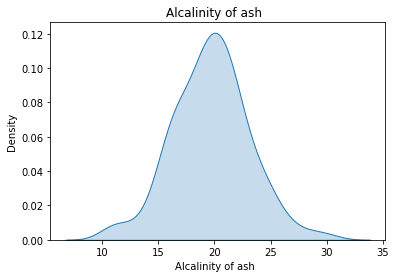

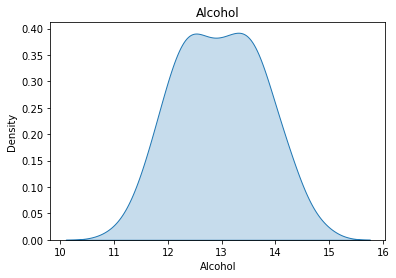

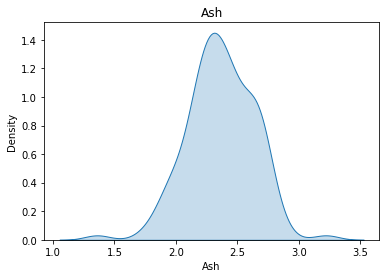

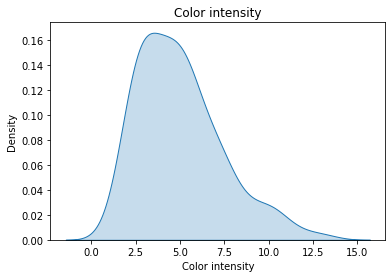

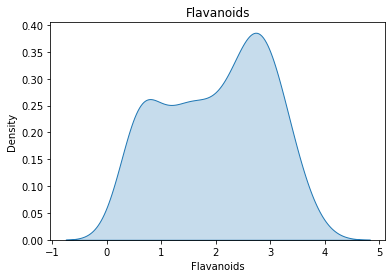

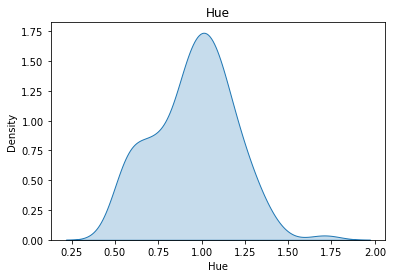

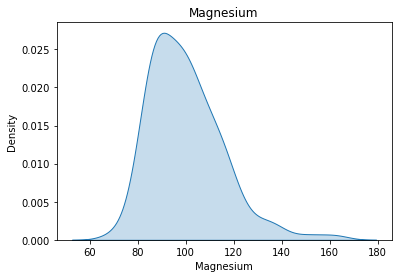

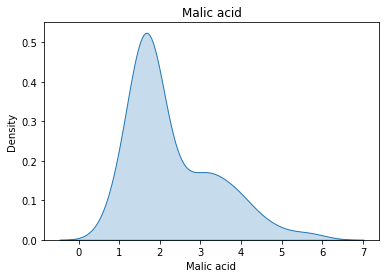

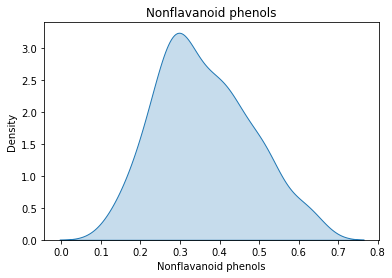

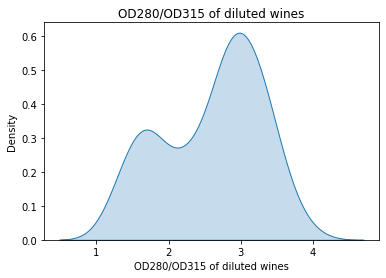

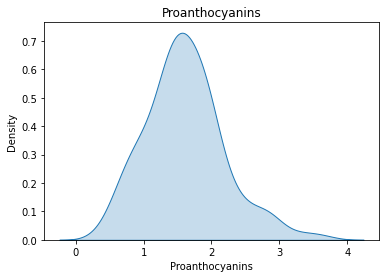

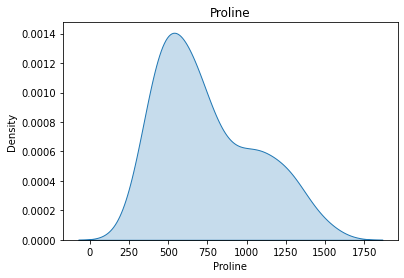

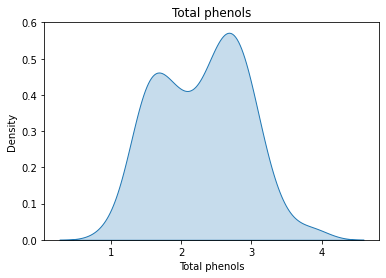

In [221]:
for i in cols:
    plt.figure()
    plt.title(i)
    sns.kdeplot(train[i],shade=True)

Text(0.5, 0, 'Number of Clusters')

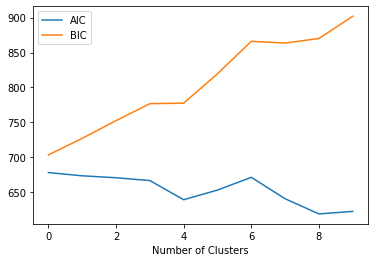

In [222]:
features = ['Alcalinity of ash  ','Nonflavanoid phenols','Proanthocyanins']
aic = []
bic = []
for i in range(1,11):
    gmm = GaussianMixture(n_components=i)
    gmm.fit(train[features])
    aic.append(gmm.aic(train[features]))
    bic.append(gmm.bic(train[features]))
plt.plot(aic,label='AIC')
plt.plot(bic,label='BIC')
plt.legend()
plt.xlabel('Number of Clusters')

In [223]:
# Let us take 2 clusters as increasing the number of clusters beyond 2 from above graph can lead to incorrect prediction.
# It can be observed after 2 AIC curve plateaus then drops after 5
#features = cols
train = dt.loc[dt['Class'] != 1]
gmm = GaussianMixture(n_components=3)
gmm.fit(train[features])
pred = gmm.predict(train[features])

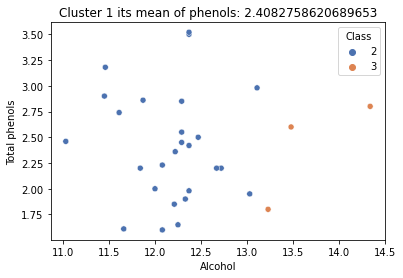

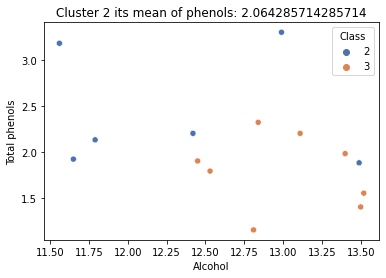

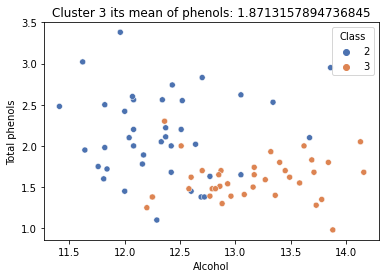

In [224]:
train['gmm_pred'] = pred
train['prob'] = 0.0
for i in range(0,3):
    sbset = train[train['gmm_pred'] == i]
    prob = gmm.predict_proba(sbset[features])[:,i]
    train.loc[train['gmm_pred'] == i,'prob'] = prob
    plt.figure()
    plt.title("Cluster "+str(i+1)+" its mean of phenols: "+str(sbset['Total phenols'].mean()))
    sns.scatterplot(sbset['Alcohol'],sbset['Total phenols'],hue=sbset['Class'],palette='deep')

0.9628567882025305


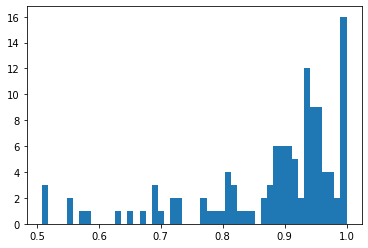

In [225]:
plt.hist(train['prob'],bins=50)
print(train['prob'].quantile(0.8))

In [226]:
train['outlier'] = 0
train.loc[train['prob']<0.9,'outlier']=1
train.groupby('Class')['outlier'].sum()

Class
2    30
3    19
Name: outlier, dtype: int64

In [227]:
pred = gmm.predict(dt[features])
dt['gmm_pred'] = pred
dt['prob'] = 0.0
for i in range(0,3):
    sbset = dt[dt['gmm_pred'] == i]
    prob = gmm.predict_proba(sbset[features])[:,i]
    dt.loc[dt['gmm_pred'] == i,'prob'] = prob
dt['outlier'] = 0
dt.loc[dt['prob']<0.9,'outlier']=1
dt.groupby('Class')['outlier'].sum()

Class
1    19
2    30
3    19
Name: outlier, dtype: int64

## Fisher Discriminant Analysis

In [228]:
# It is a supervised learning approach 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [229]:
train,test = train_test_split(dt,stratify=dt['Class'],test_size=0.3,random_state=42)
lda = LinearDiscriminantAnalysis(n_components=2,)
lda.fit(train[cols],train['Class'])
pred = lda.predict(train[cols])
print("Confusion Matrix")
print("================")
print(confusion_matrix(y_pred=pred,y_true=train['Class'],labels=[1,2,3]))
print("Metrics")
print("=======")
print(precision_recall_fscore_support(y_pred=pred,y_true=train['Class'],labels=[1,2,3]))

Confusion Matrix
[[41  0  0]
 [ 0 50  0]
 [ 0  0 33]]
Metrics
(array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([41, 50, 33], dtype=int64))


In [230]:
# Test set Metrics
pred = lda.predict(test[cols])
print("Confusion Matrix")
print("================")
print(confusion_matrix(y_pred=pred,y_true=test['Class'],labels=[1,2,3]))
print("Metrics")
print("=======")
print(precision_recall_fscore_support(y_pred=pred,y_true=test['Class'],labels=[1,2,3]))

Confusion Matrix
[[18  0  0]
 [ 1 20  0]
 [ 0  0 15]]
Metrics
(array([0.94736842, 1.        , 1.        ]), array([1.        , 0.95238095, 1.        ]), array([0.97297297, 0.97560976, 1.        ]), array([18, 21, 15], dtype=int64))


Text(0.5, 1.0, 'LDA Test Result')

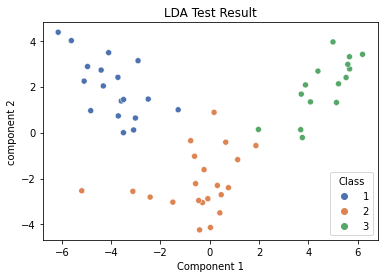

In [231]:
X = lda.transform(test[cols])
sns.scatterplot(X[:,0],X[:,1],hue=test['Class'],palette='deep')
plt.xlabel('Component 1')
plt.ylabel('component 2')
plt.title('LDA Test Result')

## Isolation Forest

In [232]:
# Just using default model parameters
# If interested one can go for hyperparameter tuning using gridsearchCV
from sklearn.ensemble import IsolationForest

In [233]:
for i in [0.05,0.1,0.2,0.3,0.4,0.5]:
    isf = IsolationForest(contamination=i)
    isf.fit(dt_normal[cols])
    pred = isf.predict(dt_normal[cols])
    print("For a contamination of "+str(i)+", % data predicted as outliers : "+str(len(np.where(pred<0)[0])*100.0/len(pred)))

For a contamination of 0.05, % data predicted as outliers : 5.042016806722689
For a contamination of 0.1, % data predicted as outliers : 10.084033613445378
For a contamination of 0.2, % data predicted as outliers : 20.168067226890756
For a contamination of 0.3, % data predicted as outliers : 30.252100840336134
For a contamination of 0.4, % data predicted as outliers : 40.33613445378151
For a contamination of 0.5, % data predicted as outliers : 49.57983193277311


<AxesSubplot:title={'center':'Isolation Forest Train result'}, xlabel='Alcohol', ylabel='Total phenols'>

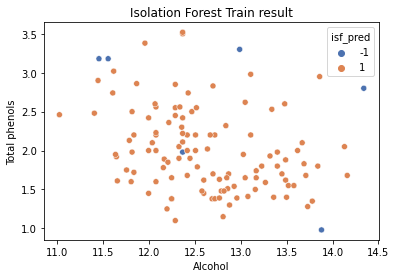

In [234]:
isf = IsolationForest(contamination=0.05)
isf.fit(dt_normal[cols])
pred = isf.predict(dt_normal[cols])
dt_normal['isf_pred'] = pred # -1 represent Outlier and 1 represent inlier
plt.figure()
plt.title("Isolation Forest Train result")
sns.scatterplot(dt_normal['Alcohol'],dt_normal['Total phenols'],hue=dt_normal['isf_pred'],palette='deep')

<AxesSubplot:title={'center':'Isolation Forest Train result'}, xlabel='Alcohol', ylabel='Total phenols'>

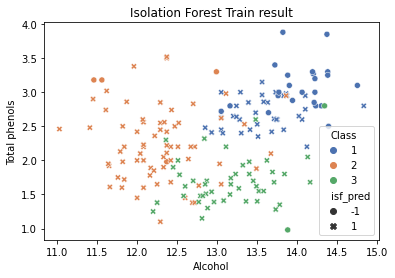

In [235]:
pred = isf.predict(dt[cols])
dt['isf_pred'] = pred # -1 represent Outlier and 1 represent inlier
plt.figure()
plt.title("Isolation Forest Train result")
sns.scatterplot(dt['Alcohol'],dt['Total phenols'],hue=dt['Class'],palette='deep',style=dt['isf_pred'])

In [236]:
dt.groupby(['Class','isf_pred'])['Class'].count()

Class  isf_pred
1      -1          23
        1          36
2      -1           4
        1          67
3      -1           2
        1          46
Name: Class, dtype: int64